In [1]:
import pandas as pd
import numpy as np
import random

# Simulate 20 SOC alerts with time windows
np.random.seed(42)
n_alerts = 20
time_stamps = [f"{i*5:02d}:00–{(i+1)*5:02d}:00" for i in range(n_alerts)]
task_types = ["Triage", "Escalation", "Correlation", "Reporting"]
alert_types = ["Suspicious Login", "Phishing Alert", "Malware Detected", "Benign Traffic"]
stress_mapping = {"Triage": "baseline", "Reporting": "baseline", "Escalation": "stress", "Correlation": "stress"}
stress_probs = {
    "baseline": lambda: round(np.random.normal(0.25, 0.05), 2),
    "stress": lambda: round(np.random.normal(0.80, 0.10), 2)
}

# Agent decision logic with error probability and utility tracking
def stress_aware_decision(stress_prob):
    if stress_prob < 0.4:
        preferred = "MONITOR"
        error_prob = 0.05
    elif stress_prob < 0.75:
        preferred = "ESCALATE"
        error_prob = 0.15
    else:
        preferred = "ESCALATE"
        error_prob = 0.40

    if random.random() < error_prob:
        decision = "ESCALATE" if preferred == "MONITOR" else "MONITOR"
    else:
        decision = preferred
    return decision

# Simulate the agent
records = []
utility = 0
for i in range(n_alerts):
    task = random.choice(task_types)
    alert = random.choice(alert_types)
    label = stress_mapping[task]
    stress = stress_probs[label]()
    expected = "ESCALATE" if label == "stress" else "MONITOR"
    decision = stress_aware_decision(stress)
    correct = (decision == expected)
    reward = 1.0 if correct else -0.5
    utility += reward
    records.append([time_stamps[i], task, alert, label, stress, decision, expected, correct, reward, utility])

# Create dataframe
df_agent = pd.DataFrame(records, columns=[
    "TimeWindow", "TaskType", "AlertType", "StressLabel", "StressProb",
    "AgentDecision", "ExpectedDecision", "Correct", "Reward", "CumulativeUtility"
])

df_agent.head()


,TimeWindow,TaskType,AlertType,StressLabel,StressProb,AgentDecision,ExpectedDecision,Correct,Reward,CumulativeUtility
0,00:00–05:00,Escalation,Suspicious Login,stress,0.85,ESCALATE,ESCALATE,True,1.0,1.0
1,05:00–10:00,Correlation,Suspicious Login,stress,0.79,ESCALATE,ESCALATE,True,1.0,2.0
2,10:00–15:00,Reporting,Benign Traffic,baseline,0.28,MONITOR,MONITOR,True,1.0,3.0
3,15:00–20:00,Correlation,Suspicious Login,stress,0.95,ESCALATE,ESCALATE,True,1.0,4.0
4,20:00–25:00,Triage,Phishing Alert,baseline,0.24,MONITOR,MONITOR,True,1.0,5.0


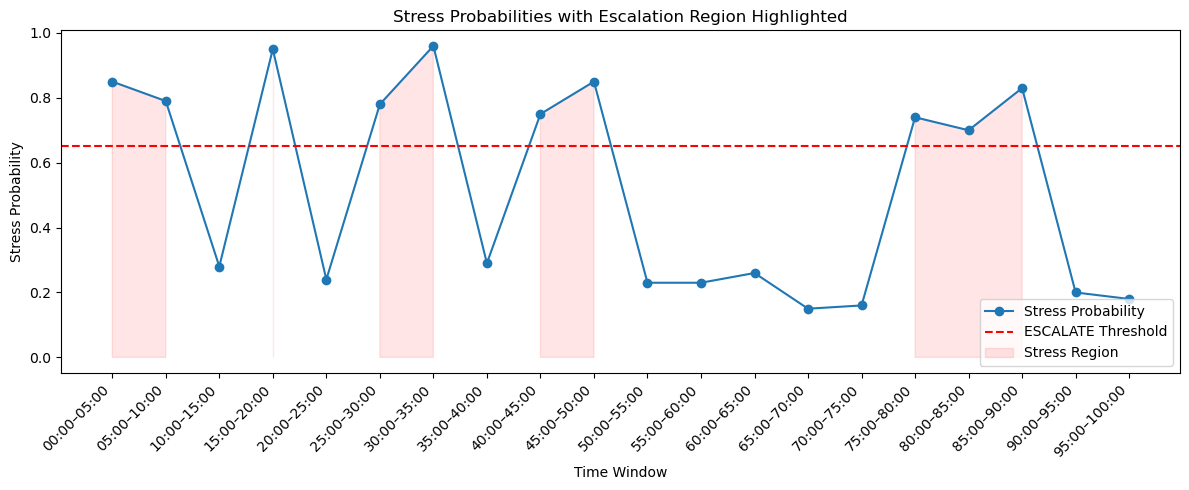

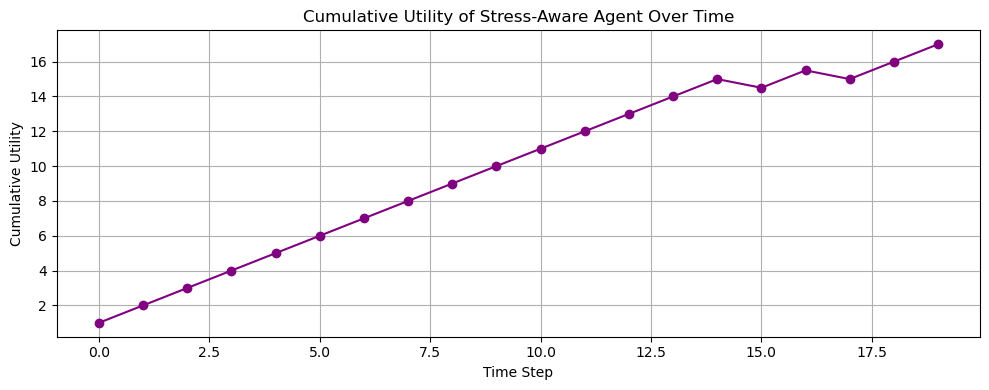

C:\Users\14377\AppData\Local\Temp\ipykernel_17632\1283628317.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_agent, x="AgentDecision", palette="Set2")


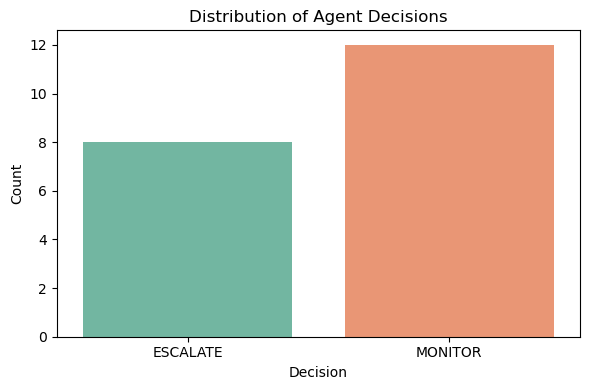

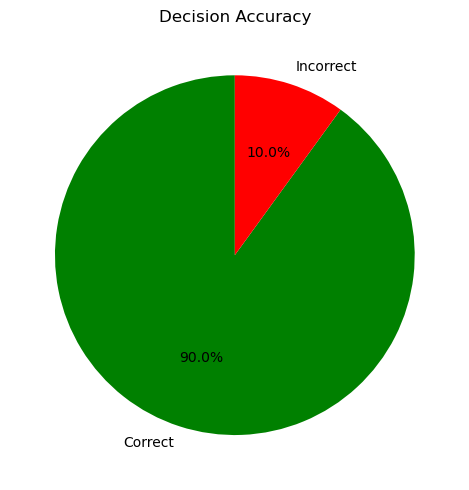

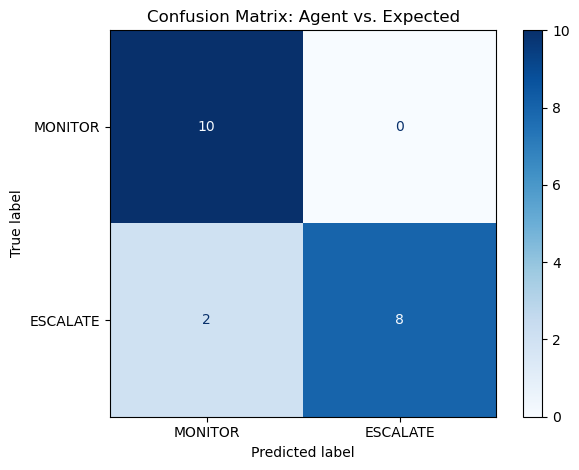

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 2-A: Plot stress probability and decisions over time
x = np.arange(len(df_agent))
y = df_agent["StressProb"].astype(float).values
stress_region = df_agent["StressLabel"].apply(lambda x: x == "stress").values

plt.figure(figsize=(12, 5))
plt.plot(x, y, label="Stress Probability", marker='o')
plt.axhline(0.65, color='r', linestyle='--', label="ESCALATE Threshold")
plt.fill_between(x, 0, y, where=stress_region, color='red', alpha=0.1, label="Stress Region")
plt.xticks(ticks=x, labels=df_agent["TimeWindow"], rotation=45, ha='right')
plt.title("Stress Probabilities with Escalation Region Highlighted")
plt.ylabel("Stress Probability")
plt.xlabel("Time Window")
plt.legend()
plt.tight_layout()
plt.show()

# Step 2-B: Plot cumulative utility over time
plt.figure(figsize=(10, 4))
plt.plot(x, df_agent["CumulativeUtility"], marker='o', color='purple')
plt.title("Cumulative Utility of Stress-Aware Agent Over Time")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Utility")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 2-C: Decision distribution bar plot
plt.figure(figsize=(6, 4))
sns.countplot(data=df_agent, x="AgentDecision", palette="Set2")
plt.title("Distribution of Agent Decisions")
plt.ylabel("Count")
plt.xlabel("Decision")
plt.tight_layout()
plt.show()

# Step 2-D: Correctness pie chart
plt.figure(figsize=(5, 5))
df_agent["Correct"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90,
                                            labels=["Correct", "Incorrect"],
                                            colors=["green", "red"])
plt.title("Decision Accuracy")
plt.ylabel("")
plt.tight_layout()
plt.show()

# Step 2-E: Confusion Matrix
cm = confusion_matrix(df_agent["ExpectedDecision"], df_agent["AgentDecision"], labels=["MONITOR", "ESCALATE"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["MONITOR", "ESCALATE"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Agent vs. Expected")
plt.tight_layout()
plt.show()


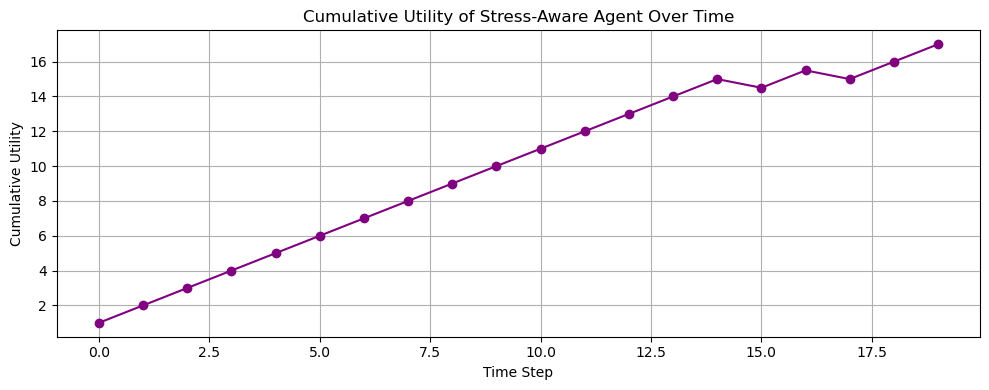

In [7]:
# Step 2-B: Plot cumulative utility over time
plt.figure(figsize=(10, 4))
plt.plot(x, df_agent["CumulativeUtility"], marker='o', color='purple')
plt.title("Cumulative Utility of Stress-Aware Agent Over Time")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Utility")
plt.grid(True)
plt.tight_layout()
plt.savefig("s2.png", dpi=300, bbox_inches='tight')
plt.show()

C:\Users\14377\AppData\Local\Temp\ipykernel_17632\1343600986.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="AgentDecision", y="StressProb", data=df_agent, palette="Set2")


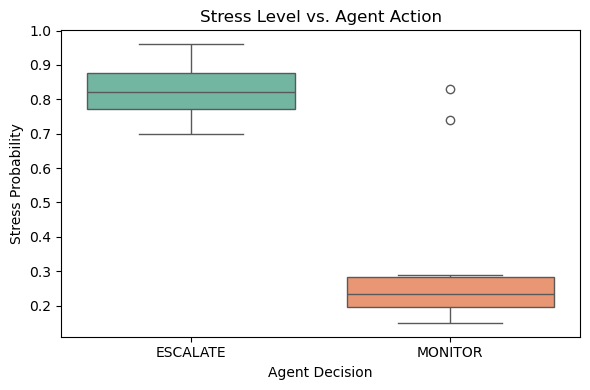

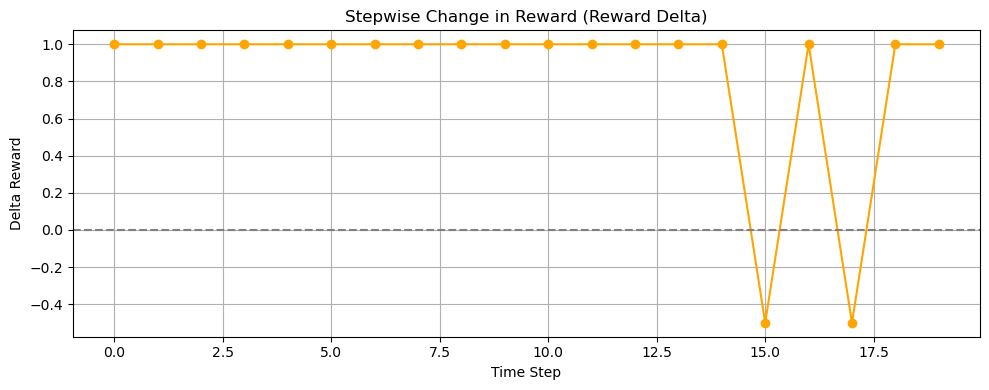

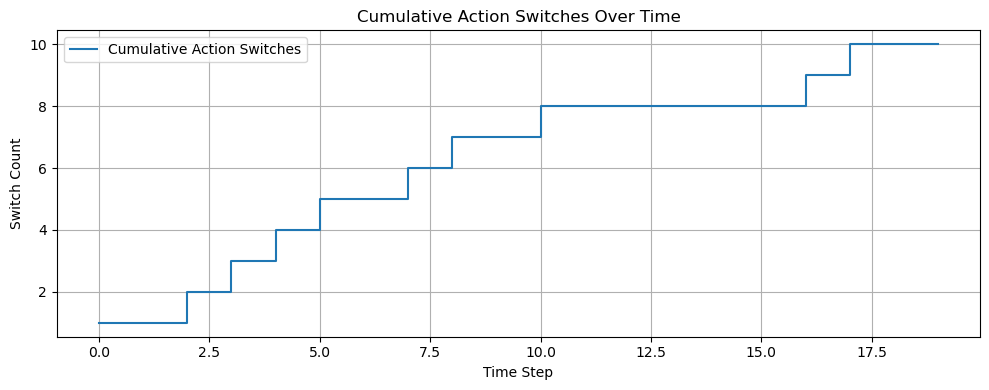

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure RewardDelta and ActionSwitch metrics are added to df_agent
df_agent["RewardDelta"] = df_agent["CumulativeUtility"].diff().fillna(df_agent["CumulativeUtility"])
df_agent["ActionSwitch"] = df_agent["AgentDecision"].ne(df_agent["AgentDecision"].shift()).astype(int)
df_agent["ActionSwitchCumsum"] = df_agent["ActionSwitch"].cumsum()

# Step 3-A: Stress vs. Correctness
# Ensure new analysis columns exist
df_agent["RewardDelta"] = df_agent["CumulativeUtility"].diff().fillna(df_agent["CumulativeUtility"])
df_agent["ActionSwitch"] = df_agent["AgentDecision"].ne(df_agent["AgentDecision"].shift()).astype(int)
df_agent["ActionSwitchCumsum"] = df_agent["ActionSwitch"].cumsum()


# Step 3-B: Stress vs. Decision Type
plt.figure(figsize=(6, 4))
sns.boxplot(x="AgentDecision", y="StressProb", data=df_agent, palette="Set2")
plt.title("Stress Level vs. Agent Action")
plt.ylabel("Stress Probability")
plt.xlabel("Agent Decision")
plt.tight_layout()
plt.show()

# Step 3-C: Reward Delta Plot
plt.figure(figsize=(10, 4))
plt.plot(df_agent.index, df_agent["RewardDelta"], marker='o', color='orange')
plt.axhline(0, linestyle="--", color='gray')
plt.title("Stepwise Change in Reward (Reward Delta)")
plt.xlabel("Time Step")
plt.ylabel("Delta Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 3-D: Action Switches
plt.figure(figsize=(10, 4))
plt.step(df_agent.index, df_agent["ActionSwitchCumsum"], where='post', label="Cumulative Action Switches")
plt.title("Cumulative Action Switches Over Time")
plt.xlabel("Time Step")
plt.ylabel("Switch Count")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


In [7]:
# Prepare agent metrics for evaluation
if "RewardDelta" not in df_agent.columns:
    df_agent["RewardDelta"] = df_agent["CumulativeUtility"].diff().fillna(df_agent["CumulativeUtility"])
    df_agent["ActionSwitch"] = df_agent["AgentDecision"].ne(df_agent["AgentDecision"].shift()).astype(int)
    df_agent["ActionSwitchCumsum"] = df_agent["ActionSwitch"].cumsum()


In [ ]:
##################################################################### CIC-IDS- 2017

In [9]:
import pandas as pd
import numpy as np
import random

# Load the dataset (adjusted to actual filename and columns)
file_path = "CIC-IDS-2017.csv"
df_raw = pd.read_csv(file_path)

# Strip extra spaces from all column names
df_raw.columns = df_raw.columns.str.strip()

# Step 4-A: Define a simple heuristic for stress labeling
df_raw["TotalPackets"] = df_raw["Total Fwd Packets"] + df_raw["Total Backward Packets"]
df_raw["StressLabel"] = df_raw.apply(
    lambda row: "stress" if (row["Flow Duration"] > 200000 or row["TotalPackets"] > 40) else "baseline",
    axis=1
)

# Assign stress probabilities
df_raw["StressProb"] = df_raw["StressLabel"].apply(
    lambda x: round(np.random.normal(0.8, 0.1), 2) if x == "stress" else round(np.random.normal(0.25, 0.05), 2)
)

# Map alert type for clarity
df_raw["AlertType"] = df_raw["StressLabel"].apply(lambda x: "DoS / Overload" if x == "stress" else "Normal Traffic")

# Agent decision logic
def stress_aware_decision(stress_prob):
    if stress_prob < 0.4:
        preferred = "MONITOR"
        error_prob = 0.05
    elif stress_prob < 0.75:
        preferred = "ESCALATE"
        error_prob = 0.15
    else:
        preferred = "ESCALATE"
        error_prob = 0.40
    return "ESCALATE" if (random.random() < error_prob and preferred == "MONITOR") else \
           "MONITOR" if (random.random() < error_prob and preferred == "ESCALATE") else preferred

df_raw["AgentDecision"] = df_raw["StressProb"].apply(stress_aware_decision)
df_raw["ExpectedDecision"] = df_raw["StressLabel"].apply(lambda x: "ESCALATE" if x == "stress" else "MONITOR")
df_raw["Correct"] = df_raw["AgentDecision"] == df_raw["ExpectedDecision"]
df_raw["Reward"] = df_raw["Correct"].apply(lambda x: 1.0 if x else -0.5)
df_raw["CumulativeUtility"] = df_raw["Reward"].cumsum()

# Final frame
df_eval = df_raw[[
    "Flow Duration", "TotalPackets", "StressLabel", "StressProb",
    "AlertType", "AgentDecision", "ExpectedDecision", "Correct", "Reward", "CumulativeUtility"
]].reset_index(drop=True)

# Preview
print(df_eval.head(10))


   Flow Duration  TotalPackets StressLabel  StressProb       AlertType  \
0              3             2    baseline        0.32  Normal Traffic   
1            109             2    baseline        0.24  Normal Traffic   
2             52             2    baseline        0.25  Normal Traffic   
3             34             2    baseline        0.18  Normal Traffic   
4              3             2    baseline        0.22  Normal Traffic   
5           1022             2    baseline        0.26  Normal Traffic   
6              4             2    baseline        0.19  Normal Traffic   
7             42             2    baseline        0.27  Normal Traffic   
8              4             2    baseline        0.22  Normal Traffic   
9              4             2    baseline        0.24  Normal Traffic   

  AgentDecision ExpectedDecision  Correct  Reward  CumulativeUtility  
0       MONITOR          MONITOR     True     1.0                1.0  
1       MONITOR          MONITOR     True  

C:\Users\14377\AppData\Local\Temp\ipykernel_8828\77074679.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="AgentDecision", y="StressProb", data=df_eval, palette="Set2")


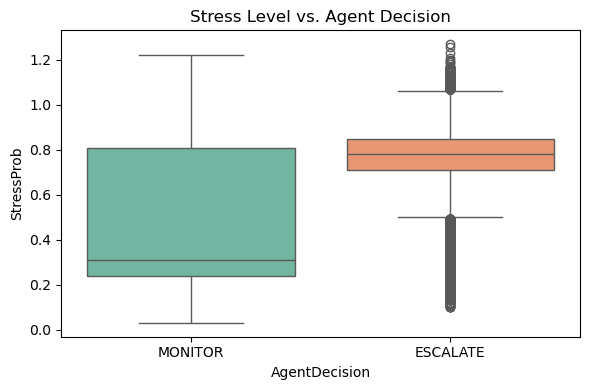

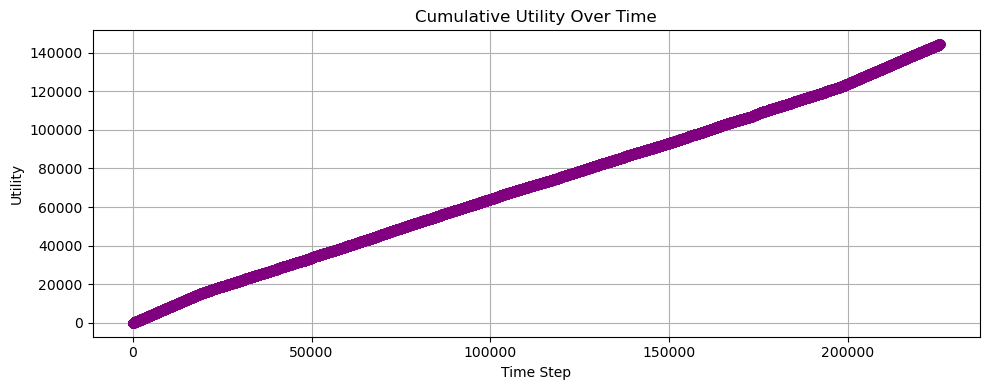

C:\Users\14377\AppData\Local\Temp\ipykernel_8828\77074679.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_eval, x="AgentDecision", palette="Set2")


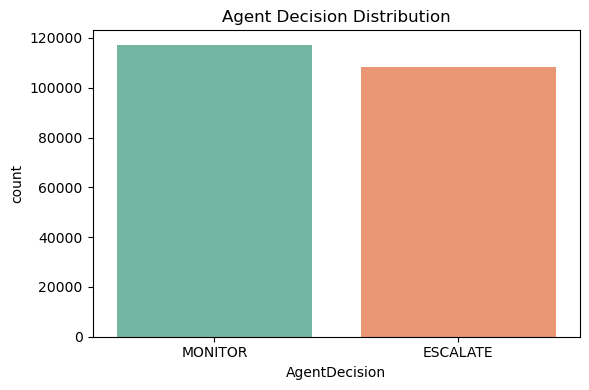

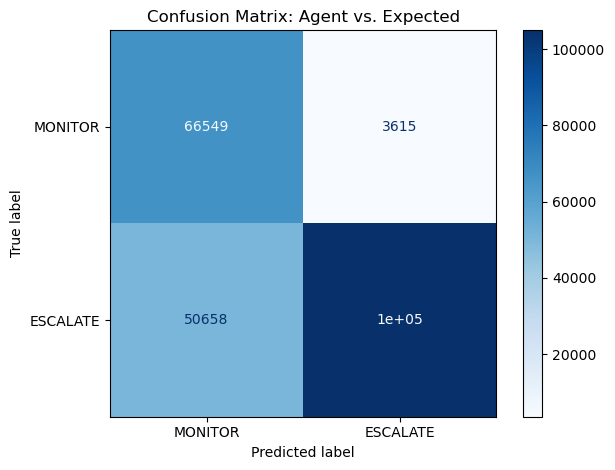

In [12]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Reload dataset
df_raw = pd.read_csv("CIC-IDS-2017.csv")
df_raw.columns = df_raw.columns.str.strip()

# Re-run simulation
df_raw["TotalPackets"] = df_raw["Total Fwd Packets"] + df_raw["Total Backward Packets"]
df_raw["StressLabel"] = df_raw.apply(
    lambda row: "stress" if (row["Flow Duration"] > 200000 or row["TotalPackets"] > 40) else "baseline",
    axis=1
)
df_raw["StressProb"] = df_raw["StressLabel"].apply(
    lambda x: round(np.random.normal(0.8, 0.1), 2) if x == "stress" else round(np.random.normal(0.25, 0.05), 2)
)
df_raw["AlertType"] = df_raw["StressLabel"].apply(lambda x: "DoS / Overload" if x == "stress" else "Normal Traffic")

def stress_aware_decision(stress_prob):
    if stress_prob < 0.4:
        preferred = "MONITOR"
        error_prob = 0.05
    elif stress_prob < 0.75:
        preferred = "ESCALATE"
        error_prob = 0.15
    else:
        preferred = "ESCALATE"
        error_prob = 0.40
    return "ESCALATE" if (random.random() < error_prob and preferred == "MONITOR") else \
           "MONITOR" if (random.random() < error_prob and preferred == "ESCALATE") else preferred

df_raw["AgentDecision"] = df_raw["StressProb"].apply(stress_aware_decision)
df_raw["ExpectedDecision"] = df_raw["StressLabel"].apply(lambda x: "ESCALATE" if x == "stress" else "MONITOR")
df_raw["Correct"] = df_raw["AgentDecision"] == df_raw["ExpectedDecision"]
df_raw["Reward"] = df_raw["Correct"].apply(lambda x: 1.0 if x else -0.5)
df_raw["CumulativeUtility"] = df_raw["Reward"].cumsum()

df_eval = df_raw[[
    "Flow Duration", "TotalPackets", "StressLabel", "StressProb",
    "AlertType", "AgentDecision", "ExpectedDecision", "Correct", "Reward", "CumulativeUtility"
]].reset_index(drop=True)

# --- Visualization ---

# Stress vs. Agent Decision
plt.figure(figsize=(6, 4))
sns.boxplot(x="AgentDecision", y="StressProb", data=df_eval, palette="Set2")
plt.title("Stress Level vs. Agent Decision")
plt.tight_layout()
plt.show()

# Cumulative Utility Over Time
plt.figure(figsize=(10, 4))
plt.plot(df_eval.index, df_eval["CumulativeUtility"], marker='o', color='purple')
plt.title("Cumulative Utility Over Time")
plt.xlabel("Time Step")
plt.ylabel("Utility")
plt.grid(True)
plt.tight_layout()
plt.show()

# Decision Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df_eval, x="AgentDecision", palette="Set2")
plt.title("Agent Decision Distribution")
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(df_eval["ExpectedDecision"], df_eval["AgentDecision"], labels=["MONITOR", "ESCALATE"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["MONITOR", "ESCALATE"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Agent vs. Expected")
plt.tight_layout()
plt.show()
